# Phase 2 Project Notebook -- Jamie Dowat 

#### Project Goals:

* Develop at least 2 variables that are well-modeled with price.
* At least 3 polished visualizations, including a QQ plot

#### Column Definitions
* View:
* Condition
* Grade


## Data Understanding

[Data Source](https://info.kingcounty.gov/assessor/DataDownload/default.aspx)

In [617]:
import pandas as pd
import numpy as np

In [618]:
df = pd.read_csv('../src/kc_house_data.csv')

In [619]:
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [620]:
df.isna().sum()

id                  0
date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2376
view               63
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3842
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64

In [621]:
wtrfront_mean = df['waterfront'].mean()

In [622]:
wtrfront_mean

0.007595858696217679

In [623]:
df.waterfront.fillna(wtrfront_mean, inplace=True)

In [624]:
# dropping view and yr_renovated
df.drop(labels=['view', 'yr_renovated', 'sqft_basement'], axis=1, inplace=True)

In [625]:
df.corr().price.sort_values(ascending=False)

price            1.000000
sqft_living      0.701917
grade            0.667951
sqft_above       0.605368
sqft_living15    0.585241
bathrooms        0.525906
bedrooms         0.308787
lat              0.306692
waterfront       0.264116
floors           0.256804
sqft_lot         0.089876
sqft_lot15       0.082845
yr_built         0.053953
condition        0.036056
long             0.022036
id              -0.016772
zipcode         -0.053402
Name: price, dtype: float64

### Engineering Variables

##### New Column : Price_per_sqft

In [626]:
df['price_per_sqft'] = df['price'] / df['sqft_living']

In [627]:
df[df['price_per_sqft']==df['price_per_sqft'].max()]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,sqft_above,yr_built,zipcode,lat,long,sqft_living15,sqft_lot15,price_per_sqft
19321,6021500970,4/7/2015,874950.0,2,1.0,1080,4000,1.0,0.0,3,7,1080,1940,98117,47.6902,-122.387,1530,4240,810.138889


In [628]:
df[df['price_per_sqft']==df['price_per_sqft'].min()]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,sqft_above,yr_built,zipcode,lat,long,sqft_living15,sqft_lot15,price_per_sqft
18248,2891000610,12/11/2014,148900.0,4,1.75,1700,6000,1.0,0.0,3,7,1700,1967,98002,47.3252,-122.208,1280,6000,87.588235


###### New column : In or out of Seattle

[Source](https://www.usmapguide.com/washington/seattle-zip-code-map/)

In [629]:
seattle_zips = [98101, 98102, 98103, 98104, 98105, 98106, 98107, 98108, 98109, 98110, 98111, 98112, 98114, 98115, 
                98116, 98117, 98118, 98119, 98121, 98122, 98124, 98125, 98126, 98129, 98131, 98132, 98133, 98134,
                98136, 98138, 98144, 98145, 98146, 98148, 98151, 98154, 98155, 98158, 98160, 98161, 98164, 98166,
                98168, 98170, 98171, 98174, 98177, 98178, 98181, 98184, 98185, 98188, 98190, 98191, 98195, 98198,
                98199]

In [630]:
df['in_city'] = np.where(df['zipcode'].isin(seattle_zips), 'Y', 'N')
df['in_city'].value_counts()

N    12624
Y     8973
Name: in_city, dtype: int64

###### New Column: avg price per sqft per ZIPCODE

In [631]:
# Svitlana's columns
list(df.columns) == ['price', 'bedrooms', 'sqft_living', 'floors', 'waterfront', 'condition',
               'grade', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
               'sqft_living15', 'price_per_sqft', 'price_per_lot_sqft', 'yard_size',
               'month_sold', 'unincorporated', 'zip_psqft', 'location_cost','decade_built']


False

In [634]:
zipcode_per_sqft = df.groupby('zipcode')['price_per_sqft'].mean()
zipcode_per_sqft

zipcode
98001    151.347966
98002    151.174091
98003    157.113414
98004    475.609615
98005    314.966998
            ...    
98177    292.982095
98178    189.172528
98188    169.007306
98198    178.434333
98199    376.659850
Name: price_per_sqft, Length: 70, dtype: float64

In [635]:
def zipcode_price(zipcode):
    try:
        return zipcode_per_sqft.loc[zipcode]
    except:
        return np.nan  

In [636]:
df.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'condition', 'grade', 'sqft_above',
       'yr_built', 'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15',
       'price_per_sqft', 'in_city'],
      dtype='object')

In [637]:
df['zip_psqft'] = df['zipcode'].apply(zipcode_price)

In [644]:
df.zip_psqft.value_counts()

369.882756    602
173.728128    589
354.157213    583
280.390083    574
363.546251    553
             ... 
423.868193    104
210.095356    100
252.327749     80
185.832062     57
568.241828     50
Name: zip_psqft, Length: 70, dtype: int64

In [642]:
df.zip_psqft.min()

148.92154328911073

In [643]:
df.zip_psqft.max()

568.2418282204763

###### New column : location cost

In [648]:
ranges = [(df['zip_psqft'] >= 100) & (df['zip_psqft'] < 200),
              (df['zip_psqft'] >= 200) & (df['zip_psqft'] < 300),
              (df['zip_psqft'] >= 300) & (df['zip_psqft'] < 400),
              (df['zip_psqft'] >= 400) & (df['zip_psqft'] < 500),
               df['zip_psqft'] >= 500]

range_labels = ['zpsft100_200', 'zpsft200_300', 'zpsft300_400', 'zpsft400_500', 'zpsft500plus']


df['location_cost'] = np.select(ranges, range_labels)

######  New column : price per LOT sqft

In [649]:
df['price_per_lot_sqft'] = df['price'] / df['sqft_lot']

###### New Column : Month Sold

In [650]:
df.date.dtype

dtype('O')

In [651]:
df['month_sold'] = df['date'].map(lambda x: int(x.split('/')[0]))

In [652]:
df['month_sold'].value_counts()

5     2414
4     2229
7     2211
6     2178
8     1939
10    1876
3     1875
9     1771
12    1470
11    1409
2     1247
1      978
Name: month_sold, dtype: int64

###### New Column: SEASON Sold

In [653]:
winter = [12,1,2]
fall = [9,10,11]
summer = [6,7,8]
spring = [3,4,5]

season_vals = []

for month in df['month_sold']:
    if month in winter:
        season_vals.append('winter')
    elif month in fall:
        season_vals.append('fall')
    elif month in summer:
        season_vals.append('summer')
    else:
        season_vals.append('spring')
        
df['season_sold'] = pd.DataFrame(season_vals)
        
df['season_sold'].value_counts()

spring    6518
summer    6328
fall      5056
winter    3695
Name: season_sold, dtype: int64

##### New Column: Year Sold

In [654]:
df['year_sold'] = df['date'].map(lambda x: int(x.split('/')[2]))
df.year_sold.value_counts()

2014    14622
2015     6975
Name: year_sold, dtype: int64

###### New Column: Decade Built

In [655]:
decades = [(df['yr_built'] >= 1900) & (df['yr_built'] < 1910),
               (df['yr_built'] >= 1910) & (df['yr_built'] < 1920),
               (df['yr_built'] >= 1920) & (df['yr_built'] < 1930),
               (df['yr_built'] >= 1930) & (df['yr_built'] < 1940),
               (df['yr_built'] >= 1940) & (df['yr_built'] < 1950),
               (df['yr_built'] >= 1950) & (df['yr_built'] < 1960),
               (df['yr_built'] >= 1960) & (df['yr_built'] < 1970),
               (df['yr_built'] >= 1970) & (df['yr_built'] < 1980),
               (df['yr_built'] >= 1980) & (df['yr_built'] < 1990),
               (df['yr_built'] >= 1990) & (df['yr_built'] < 2000),
               (df['yr_built'] >= 2000) & (df['yr_built'] < 2010),
               (df['yr_built'] >= 2010) & (df['yr_built'] < 2020)]

decade_names = ['1900_1910', '1910_1920', '1920_1930', '1930_1940', 
                '1940_1950', '1950_1960', '1960_1970', '1970_1980', 
                '1980_1990', '1990_2000', '2000_2010', '2010_2020']

df['decade_built'] = np.select(decades, decade_names, np.nan)

In [656]:
df.decade_built.value_counts()

2000_2010    3515
1960_1970    2658
1950_1960    2450
1970_1980    2285
1980_1990    2281
1990_2000    2232
1940_1950    1763
2010_2020    1241
1920_1930    1192
1910_1920     805
1900_1910     645
1930_1940     530
Name: decade_built, dtype: int64

###### New Column : built within 40 yr block

In [657]:
sections = [decade_names[:4], decade_names[4:8], decade_names[8:]]
sections[0]

['1900_1910', '1910_1920', '1920_1930', '1930_1940']

In [658]:
section_names = []
for section in sections:
    for decade in df['decade_built']:
        if decade in section:
            section_names.append(section[0][:4]+"_"+section[3][5:])
        
df['40yr_section'] = pd.DataFrame(section_names)
df['40yr_section'].value_counts()

1980_2020    9269
1940_1980    9156
1900_1940    3172
Name: 40yr_section, dtype: int64

###### New Column : built before or after ???

###### New Column: incorporated vs not incorporated

In [659]:
unincorporated_zipcodes = [98019, 98014, 98024, 98065, 98038, 98051, 98022, 98045, 98288, 98224,98051, 98029, 98014, 98077, 98053, 98010, 98070]
df['unincorporated'] = np.where(df['zipcode'].isin(unincorporated_zipcodes), 'Y', 'N')

In [660]:
df['unincorporated'].value_counts()

N    18714
Y     2883
Name: unincorporated, dtype: int64

In [661]:
df_grade_mean = df.groupby('grade').mean()

In [662]:
df_grade_count = df.groupby('grade').count()

In [663]:
df.groupby('grade')['price'].agg([np.mean,np.median])

,mean,median
grade,,
3,2.620000e+05,262000.0
4,2.120019e+05,200000.0
5,2.485240e+05,228700.0
6,3.019166e+05,275276.5
7,4.025946e+05,375000.0
8,5.429868e+05,510000.0
9,7.737382e+05,720000.0
10,1.072347e+06,914327.0
11,1.497792e+06,1280000.0


In [664]:
grade_mean_median = df.groupby('grade')['price_per_sqft'].agg([np.mean,np.median])

In [665]:
df.groupby('grade')['price_per_sqft'].mean().values

array([503.84615385, 342.0123655 , 278.93360926, 270.98989171,
       251.88401441, 258.13953459, 275.83939347, 307.74632471,
       342.47894699, 403.60211783, 483.79669319])

### Visualizing Data 

In [666]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('seaborn')

In [667]:
cols = df.drop(labels=['id', 'zipcode', 'lat', 'long', 'date'], axis=1).columns
new_df = df[cols].corr()
new_df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,sqft_above,yr_built,sqft_living15,sqft_lot15,price_per_sqft,zip_psqft,price_per_lot_sqft,month_sold,year_sold
price,1.000000,0.308787,0.525906,0.701917,0.089876,0.256804,0.264116,0.036056,0.667951,0.605368,0.053953,0.585241,0.082845,0.556056,0.532667,0.308066,-0.009928,0.003727
bedrooms,0.308787,1.000000,0.514508,0.578212,0.032471,0.177944,-0.002257,0.026496,0.356563,0.479386,0.155670,0.393406,0.030690,-0.205905,-0.006412,-0.062884,-0.001046,-0.009949
bathrooms,0.525906,0.514508,1.000000,0.755758,0.088373,0.502582,0.063522,-0.126479,0.665838,0.686668,0.507173,0.569884,0.088303,-0.090285,0.067164,0.202578,0.007543,-0.026577
sqft_living,0.701917,0.578212,0.755758,1.000000,0.173453,0.353953,0.104492,-0.059445,0.762779,0.876448,0.318152,0.756402,0.184342,-0.091167,0.090229,0.022404,0.012112,-0.029014
sqft_lot,0.089876,0.032471,0.088373,0.173453,1.000000,-0.004814,0.021519,-0.008830,0.114731,0.184139,0.052946,0.144763,0.718204,-0.034749,-0.109963,-0.206256,-0.002591,0.005628


<AxesSubplot:>

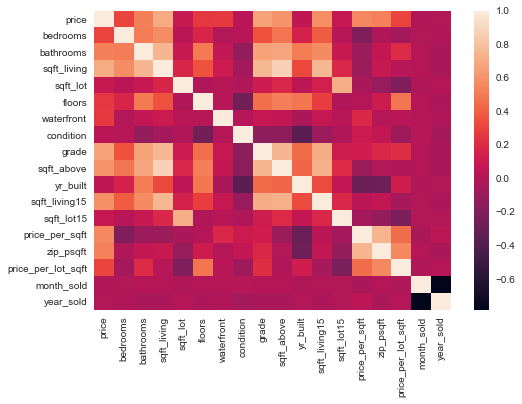

In [668]:
sns.heatmap(new_df)

In [669]:
# Table with highest correlations

best_corrs = new_df.corr().abs().stack().reset_index().sort_values(0, ascending=False)

# zip the variable name columns (Which were only named level_0 and level_1 by default) in a new column named "pairs"
best_corrs['pairs'] = list(zip(best_corrs.level_0, best_corrs.level_1))

# set index to pairs
best_corrs.set_index(['pairs'], inplace = True)

#d rop level columns
best_corrs.drop(columns=['level_1', 'level_0'], inplace = True)

# rename correlation column as cc rather than 0
best_corrs.columns = ['cc']

# drop duplicates. This could be dangerous if you have variables perfectly correlated with variables other than themselves.
# for the sake of exercise, kept it in.
best_corrs.drop_duplicates(inplace=True)

In [670]:
best_corrs[best_corrs['cc']>.7]

,cc
pairs,
"(price, price)",1.000000
"(sqft_above, sqft_living)",0.975755
"(month_sold, year_sold)",0.971359
"(sqft_living, sqft_living15)",0.951870
"(sqft_above, sqft_living15)",0.943121
"(sqft_lot, sqft_lot15)",0.942976
"(grade, sqft_above)",0.934924
"(bathrooms, sqft_above)",0.927436
"(sqft_living, grade)",0.926181


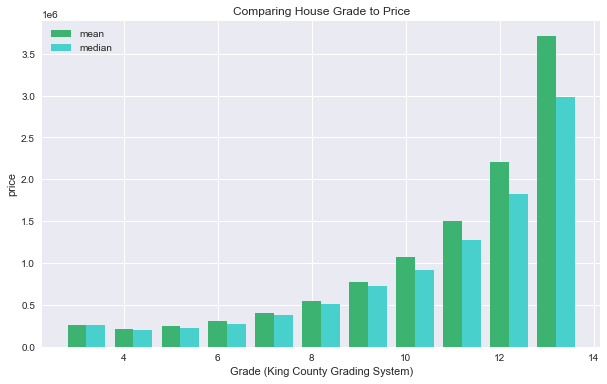

In [538]:
fig, ax = plt.subplots(figsize=(10,6))

grade_means = df.groupby('grade')['price'].mean().values
grade_medians = df.groupby('grade')['price'].median().values

w = 0.4
bar1 = [i for i in range(3,14)]
bar2 = [i+w for i in bar1]

ax.bar(bar1, grade_means, width=w, color='mediumseagreen', label='mean', align='center')
ax.bar(bar2, grade_medians, width=w, color='mediumturquoise', label='median', align='center')

# x and y vals; use bottom parameter to make stacked
ax.set_xlabel('Grade (King County Grading System)')
ax.set_ylabel('price')
ax.set_title('Comparing House Grade to Price')
ax.legend()

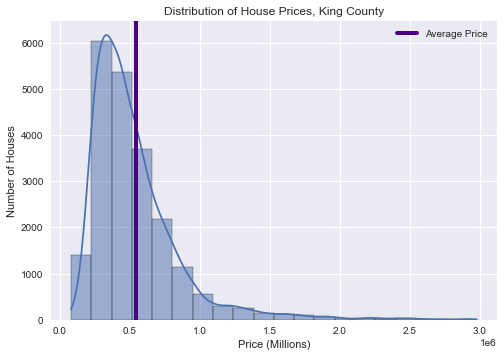

In [823]:
# Distribution of prices
sns.histplot(df['price'][df['price']<3000000], bins=20, kde=True)
plt.title('Distribution of House Prices, King County')
plt.axvline(x=df['price'].mean(), ymin=0, ymax=6000, lw=4, color='indigo', label='Average Price')
plt.xlabel('Price (Millions)')
plt.ylabel('Number of Houses')
plt.legend()

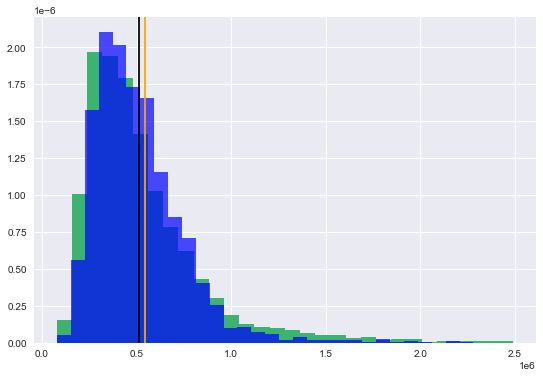

In [540]:
# comparing price distributions for uninc and inc areas
inc = df['price'][(df['unincorporated']==0)&(df['price']<2500000)]
uninc = df['price'][(df['unincorporated']==1)&(df['price']<2500000)]

fig, ax = plt.subplots(figsize=(9,6))

ax.hist(inc, bins=30, color='mediumseagreen', density=True) # inc
ax.hist(uninc, bins=30, color='blue', density=True, alpha=.7) # not inc

ax.axvline(x=df['price'][(df['unincorporated']==0)].mean(), color='orange') # incorporated
ax.axvline(x=df['price'][(df['unincorporated']==1)].mean(), color='black') # not inc

<AxesSubplot:xlabel='sqft_living', ylabel='price'>

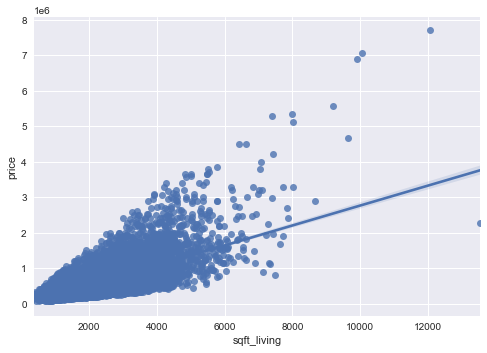

In [586]:
# Distribution of sqft_living and price
sns.regplot(x=df.sqft_living, y=df.price)

###### Distribution of prices - city vs out of city

[Source](https://stackoverflow.com/questions/44552489/plotting-multiple-boxplots-in-seaborn)

In [598]:
in_city = df[['price', 'in_city']][df['in_city']=='Y']
out_of_city = df[['price', 'in_city']][df['in_city']=='N']

cdf = pd.concat([in_city, out_of_city])  
cdf.head()# CONCATENATE
#mdf = pd.melt(cdf, id_vars=['price'], var_name=['in_city']) 
#mdf.head()# MELT

,price,in_city
0,221900.0,Y
1,538000.0,Y
3,604000.0,Y
7,291850.0,Y
8,229500.0,Y


<AxesSubplot:xlabel='in_city', ylabel='price'>

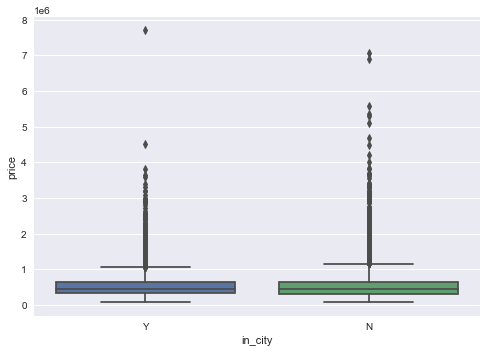

In [601]:
sns.boxplot(x='in_city', y='price', data=cdf)

Text(0.5, 0, 'In City? Y or N')

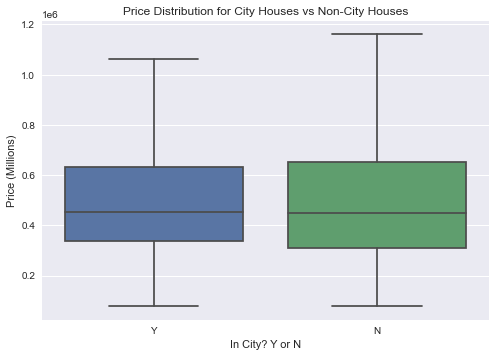

In [810]:
sns.boxplot(x='in_city', y='price', data=cdf, showfliers=False)
plt.title('Price Distribution for City Houses vs Non-City Houses')  
plt.ylabel('Price (Millions)')
plt.xlabel('In City? Y or N')

###### Distribution of prices per grade

###### Year built distribution

<AxesSubplot:xlabel='yr_built', ylabel='Count'>

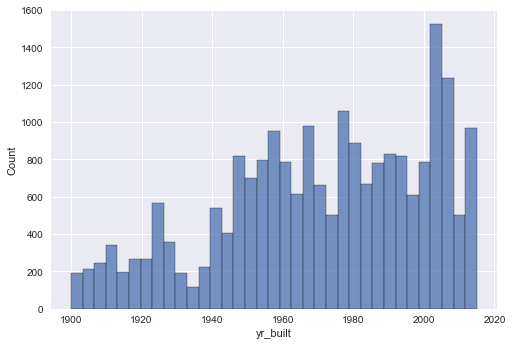

In [552]:
sns.histplot(df.yr_built)

<AxesSubplot:xlabel='zip_psqft', ylabel='Count'>

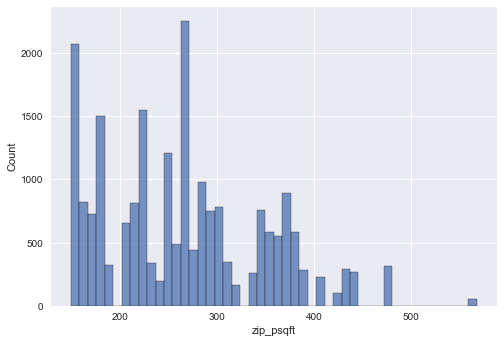

In [641]:
sns.histplot(df.zip_psqft)

###### Waterfront views? 

In [221]:
df_wf = df
df_wf.dropna(inplace=True, subset=['waterfront'])

In [222]:
df_wf.isna().sum()

id                   0
date                 0
price                0
bedrooms             0
bathrooms            0
sqft_living          0
sqft_lot             0
floors               0
waterfront           0
view                57
condition            0
grade                0
sqft_above           0
sqft_basement        0
yr_built             0
yr_renovated      3412
zipcode              0
lat                  0
long                 0
sqft_living15        0
sqft_lot15           0
price_per_sqft       0
month_sold           0
unincorporated       0
dtype: int64

In [223]:
df_wf.waterfront.value_counts()

0.0    19075
1.0      146
Name: waterfront, dtype: int64

In [224]:
df_wf['price'][df_wf['waterfront']==1.0].mean()

1717214.7260273972

In [225]:
df_wf['price'][df_wf['waterfront']==0.0].mean()

532641.9866841416

Text(0, 0.5, 'Density')

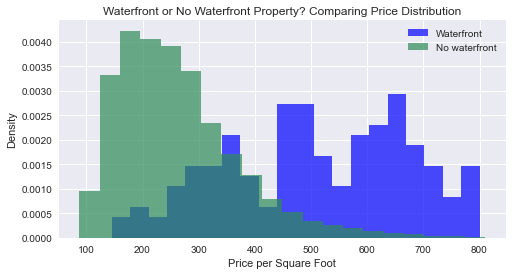

In [817]:
waterfront = df_wf['price_per_sqft'][df_wf['waterfront']==1]
no_waterfront = df_wf['price_per_sqft'][df_wf['waterfront']==0]
fig, ax = plt.subplots(figsize=(8,4))
ax.hist(waterfront, bins=20, color='blue', density=True, alpha=.7, label='Waterfront')
ax.hist(no_waterfront, bins=20, color='seagreen', density=True, alpha=.7, label='No waterfront')
ax.legend()
ax.set_title('Waterfront or No Waterfront Property? Comparing Price Distribution')
ax.set_xlabel('Price per Square Foot')
ax.set_ylabel('Density')

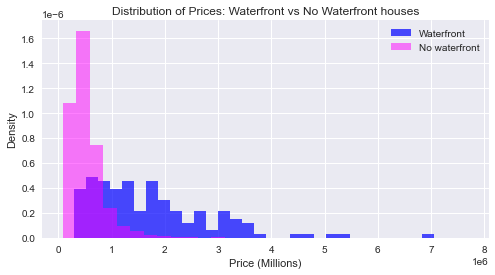

In [815]:
waterfront = df_wf['price'][df_wf['waterfront']==1]
no_waterfront = df_wf['price'][df_wf['waterfront']==0]
fig, ax = plt.subplots(figsize=(8,4))
ax.hist(waterfront, bins=30, color='blue', density=True, alpha=.7, label='Waterfront')
ax.hist(no_waterfront, bins=30, color='magenta', density=True, alpha=.5, label='No waterfront')
ax.set_title('Distribution of Prices: Waterfront vs No Waterfront houses')
ax.set_xlabel('Price (Millions)')
ax.set_ylabel('Density')
ax.legend()

### GeoPandas

In [841]:
import geopandas as gpd

In [842]:
kc = gpd.read_file('../src/shapefile/Zipcodes_for_King_County_and_Surrounding_Area_(Shorelines)___zipcode_shore_area.shp')

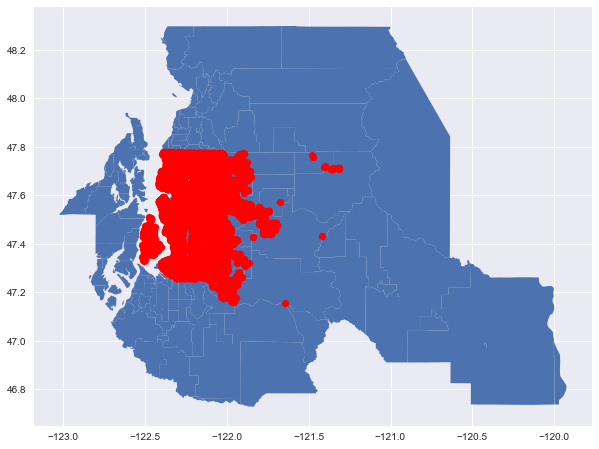

In [850]:
fig, ax = plt.subplots(figsize=(10,10))
kc.plot(ax=ax)
ax.scatter(df['long'], df['lat'], color='red')

In [845]:
df[['lat', 'long']].head()

,lat,long
0,47.5112,-122.257
1,47.7210,-122.319
2,47.7379,-122.233
3,47.5208,-122.393
4,47.6168,-122.045


## PreProcessing Data for Modeling 

In [672]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

##### DataFrame for Modeling

In [720]:
cols = df.drop(labels=['id', 'zipcode', 'lat', 'long', 'date'], axis=1).columns
mod_df = df[cols]

#### CATEGORICALS

###### bedrooms

In [721]:
bedroom_series = pd.Series(mod_df['bedrooms']).astype('category')

# Can concat to original data frame
bedrooms = pd.get_dummies(bedroom_series, prefix='bed', drop_first=True)
bedrooms.describe()

,bed_2,bed_3,bed_4,bed_5,bed_6,bed_7,bed_8,bed_9,bed_10,bed_11,bed_33
count,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.00000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000
mean,0.127796,0.454878,0.318655,0.074131,0.012594,0.00176,0.000602,0.000278,0.000139,0.000046,0.000046
std,0.333870,0.497971,0.465966,0.261989,0.111518,0.04191,0.024528,0.016666,0.011785,0.006805,0.006805
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,1.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000


###### bathrooms

In [722]:
bathrooms_series = pd.Series(mod_df['bathrooms'])

cat_bathrooms = bathrooms_series.astype('category')

# Can concat to original data frame
bathrooms = pd.get_dummies(cat_bathrooms, prefix='bath', drop_first=True)

###### season sold (se)

In [723]:
seasons_series = pd.Series(df['season_sold'])

cat_seasons = seasons_series.astype('category')

# Can concat to original data frame
seasons = pd.get_dummies(cat_seasons, prefix='se', drop_first=True)
seasons.describe()

,se_spring,se_summer,se_winter
count,21597.000000,21597.000000,21597.000000
mean,0.301801,0.293004,0.171089
std,0.459050,0.455151,0.376595
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,1.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000


###### waterfront (wf) 

In [724]:
wf_series = pd.Series(df['waterfront'])

cat_wf = wf_series.astype('category')

# Can concat to original data frame
wf = pd.get_dummies(cat_wf, prefix='wf', drop_first=True)
wf.describe()

,wf_0.007595858696217679,wf_1.0
count,21597.000000,21597.000000
mean,0.110015,0.006760
std,0.312916,0.081944
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,0.000000
max,1.000000,1.000000


###### grade

In [725]:
grade_series = pd.Series(df['grade']).astype('category')

# Can concat to original data frame
grade = pd.get_dummies(grade_series, prefix='gr', drop_first=True)
grade.describe()

,gr_4,gr_5,gr_6,gr_7,gr_8,gr_9,gr_10,gr_11,gr_12,gr_13
count,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000
mean,0.001250,0.011205,0.094365,0.415521,0.280826,0.121082,0.052507,0.018475,0.004121,0.000602
std,0.035337,0.105263,0.292343,0.492823,0.449413,0.326230,0.223053,0.134664,0.064064,0.024528
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


###### in_city

In [726]:
in_city_series = pd.Series(df['in_city']).astype('category')

# Can concat to original data frame
in_city = pd.get_dummies(in_city_series, prefix='incity', drop_first=True)
in_city.describe()

,incity_Y
count,21597.000000
mean,0.415474
std,0.492815
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


###### yr_built

In [727]:
yrbuilt_series = pd.Series(df['yr_built']).astype('category')

# Can concat to original data frame
yrbuilt = pd.get_dummies(yrbuilt_series, prefix='yrb', drop_first=True)
yrbuilt.describe()

,yrb_1901,yrb_1902,yrb_1903,yrb_1904,yrb_1905,yrb_1906,yrb_1907,yrb_1908,yrb_1909,yrb_1910,...,yrb_2006,yrb_2007,yrb_2008,yrb_2009,yrb_2010,yrb_2011,yrb_2012,yrb_2013,yrb_2014,yrb_2015
count,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.00000,21597.000000,21597.000000,21597.000000,21597.000000,...,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.00000
mean,0.001343,0.001250,0.002130,0.002084,0.003426,0.00426,0.003010,0.003982,0.004352,0.006205,...,0.020975,0.019308,0.016993,0.010650,0.006621,0.006019,0.007871,0.009307,0.025883,0.00176
std,0.036620,0.035337,0.046103,0.045600,0.058436,0.06513,0.054779,0.062979,0.065831,0.078526,...,0.143304,0.137609,0.129248,0.102648,0.081103,0.077352,0.088373,0.096024,0.158791,0.04191
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000


###### decade_built

In [728]:
decade_series = pd.Series(df['decade_built']).astype('category')

# Can concat to original data frame
decades = pd.get_dummies(decade_series, prefix='decb', drop_first=True)
decades.describe()

,decb_1910_1920,decb_1920_1930,decb_1930_1940,decb_1940_1950,decb_1950_1960,decb_1960_1970,decb_1970_1980,decb_1980_1990,decb_1990_2000,decb_2000_2010,decb_2010_2020
count,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000
mean,0.037274,0.055193,0.024540,0.081632,0.113442,0.123073,0.105802,0.105617,0.103348,0.162754,0.057462
std,0.189436,0.228362,0.154723,0.273809,0.317139,0.328528,0.307591,0.307353,0.304420,0.369150,0.232728
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


###### 40yr_section

In [729]:
fortyyr_series = pd.Series(df['40yr_section']).astype('category')

# Can concat to original data frame
fortyyr = pd.get_dummies(fortyyr_series, prefix='fortyyr', drop_first=True)
fortyyr.describe()

,fortyyr_1940_1980,fortyyr_1980_2020
count,21597.000000,21597.000000
mean,0.423948,0.429180
std,0.494194,0.494971
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,1.000000,1.000000
max,1.000000,1.000000


######  month sold (mo)

In [730]:
months_series = pd.Series(df['month_sold'])

cat_months = months_series.astype('category')

# Can concat to original data frame
months = pd.get_dummies(cat_months, prefix='mo', drop_first=True)
months.describe()

,mo_2,mo_3,mo_4,mo_5,mo_6,mo_7,mo_8,mo_9,mo_10,mo_11,mo_12
count,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000
mean,0.057740,0.086818,0.103209,0.111775,0.100847,0.102375,0.089781,0.082002,0.086864,0.065241,0.068065
std,0.233256,0.281574,0.304238,0.315096,0.301133,0.303148,0.285874,0.274374,0.281642,0.246956,0.251863
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


###### floors

In [731]:
floor_series = pd.Series(df['floors']).astype('category')

# Can concat to original data frame
floors = pd.get_dummies(floor_series, prefix='flr', drop_first=True)
floors.describe()

,flr_1.5,flr_2.0,flr_2.5,flr_3.0,flr_3.5
count,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000
mean,0.088438,0.381303,0.007455,0.028291,0.000324
std,0.283938,0.485718,0.086020,0.165807,0.018001
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000


###### condition

In [732]:
condition_series = pd.Series(df['condition']).astype('category')

# Can concat to original data frame
conditions = pd.get_dummies(condition_series, prefix='cond', drop_first=True)
conditions.describe()

,cond_2,cond_3,cond_4,cond_5
count,21597.000000,21597.000000,21597.000000,21597.000000
mean,0.007871,0.649164,0.262861,0.078761
std,0.088373,0.477243,0.440198,0.269372
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.000000,0.000000,0.000000
75%,0.000000,1.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000


###### location cost

In [733]:
df['location_cost']

0        zpsft100_200
1        zpsft200_300
2        zpsft200_300
3        zpsft300_400
4        zpsft200_300
             ...     
21592    zpsft300_400
21593    zpsft200_300
21594    zpsft300_400
21595    zpsft200_300
21596    zpsft300_400
Name: location_cost, Length: 21597, dtype: object

In [734]:
lc_series = pd.Series(df['location_cost']).astype('category')

# Can concat to original data frame
lc = pd.get_dummies(lc_series, drop_first=True)

###### unincorporated (inc)

In [735]:
inc_series = pd.Series(df['unincorporated']).astype('category')

# Can concat to original data frame
inc = pd.get_dummies(inc_series, prefix='inc', drop_first=True)
inc.head()

,inc_Y
0,0
1,0
2,0
3,0
4,0


#### Join categoricals to mod_df

In [736]:
mod_df.location_cost.value_counts()

zpsft200_300    10183
zpsft100_200     5440
zpsft300_400     4712
zpsft400_500     1212
zpsft500plus       50
Name: location_cost, dtype: int64

In [737]:
mod_df.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'condition', 'grade', 'sqft_above', 'yr_built',
       'sqft_living15', 'sqft_lot15', 'price_per_sqft', 'in_city', 'zip_psqft',
       'location_cost', 'price_per_lot_sqft', 'month_sold', 'season_sold',
       'year_sold', 'decade_built', '40yr_section', 'unincorporated'],
      dtype='object')

In [763]:
continuous = mod_df[['price', 'sqft_living', 'sqft_lot', 'sqft_above', 
                     'sqft_living15', 'sqft_lot15', 'price_per_sqft',
                    'zip_psqft', 'price_per_lot_sqft']]

In [764]:
mod_df = pd.concat([continuous, bedrooms, bathrooms, seasons, wf, grade, in_city, yrbuilt,
                    decades, fortyyr, months, floors, conditions, lc, inc], axis=1)

In [765]:
mod_df.head()

,price,sqft_living,sqft_lot,sqft_above,sqft_living15,sqft_lot15,price_per_sqft,zip_psqft,price_per_lot_sqft,bed_2,...,flr_3.5,cond_2,cond_3,cond_4,cond_5,zpsft200_300,zpsft300_400,zpsft400_500,zpsft500plus,inc_Y
0,221900.0,1180,5650,1180,1340,5650,188.050847,189.172528,39.274336,0,...,0,0,1,0,0,0,0,0,0,0
1,538000.0,2570,7242,2170,1690,7639,209.338521,282.680191,74.288870,0,...,0,0,1,0,0,1,0,0,0,0
2,180000.0,770,10000,770,2720,8062,233.766234,225.145368,18.000000,1,...,0,0,1,0,0,1,0,0,0,0
3,604000.0,1960,5000,1050,1360,5000,308.163265,337.245108,120.800000,0,...,0,0,0,0,1,0,1,0,0,0
4,510000.0,1680,8080,1680,1800,7503,303.571429,265.686627,63.118812,0,...,0,0,1,0,0,1,0,0,0,0


###### Stepwise selection function

In [783]:
def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if (worst_pval > threshold_out) & (len(included)>0):
            changed=True
            worst_feature = pvalues.argmax()
            if worst_feature in included:
                included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

###### Optimizes R-squared value

In [767]:
def forward_selected(data, response):
    """Linear model designed by forward selection.

    Parameters:
    -----------
    data : pandas DataFrame with all possible predictors and response

    response: string, name of response column in data

    Returns:
    --------
    model: an "optimal" fitted statsmodels linear model
           with an intercept
           selected by forward selection
           evaluated by adjusted R-squared
    """
    remaining = set(data.columns)
    remaining.remove(response)
    selected = []
    current_score, best_new_score = 0.0, 0.0
    while remaining and current_score == best_new_score:
        scores_with_candidates = []
        for candidate in remaining:
            formula = "{} ~ {} + 1".format(response,
                                           ' + '.join(selected + [candidate]))
            score = smf.ols(formula, data).fit().rsquared_adj
            scores_with_candidates.append((score, candidate))
        scores_with_candidates.sort()
        best_new_score, best_candidate = scores_with_candidates.pop()
        if current_score < best_new_score:
            remaining.remove(best_candidate)
            selected.append(best_candidate)
            current_score = best_new_score
    formula = "{} ~ {} + 1".format(response,
                                   ' + '.join(selected))
    model = smf.ols(formula, data).fit()
    return model

In [768]:
X = mod_df.drop(labels='price', axis=1)

In [769]:
Y = mod_df.price

In [770]:
xcols = list(mod_df.drop(labels='price', axis=1).columns)

### MODEL NUMERO UNO

In [776]:
len(Y)

21597

In [778]:
model = sm.OLS(Y.astype(float), sm.add_constant(X.astype(float))).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.915
Model:                            OLS   Adj. R-squared:                  0.914
Method:                 Least Squares   F-statistic:                     1141.
Date:                Wed, 17 Feb 2021   Prob (F-statistic):               0.00
Time:                        17:39:00   Log-Likelihood:            -2.8076e+05
No. Observations:               21597   AIC:                         5.619e+05
Df Residuals:                   21394   BIC:                         5.635e+05
Df Model:                         202                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                   -5.812e+05   1.05e+05     -5.536      0.000   -7.87e+05   -3.75e+05
sqft_living               263.3755      2.618    100.600      0.000     258.244     268.507
sqft_lot                   -0.0458      0.026     -1.764      0.078      -0.097       0.005
sqft_above                 -5.4212      2.605     -2.081      0.037     -10.527      -0.315
sqft_living15             -10.6595      1.951     -5.463      0.000     -14.484      -6.835
sqft_lot15                 -0.2042      0.040     -5.111      0.000      -0.283      -0.126
price_per_sqft           1830.6502     13.042    140.364      0.000    1805.087    1856.214
zip_psqft                 205.5066     34.590      5.941      0.000     137.708     273.305
price_per_lot_sqft        148.6446     14.825     10.027      0.000     119.587     177.702
bed_2                    7.479e+04   8356.150      8.951      0.000    5.84e+04    9.12e+04
bed_3                    1.212e+05   8406.674     14.418      0.000    1.05e+05    1.38e+05
bed_4                    1.114e+05   8597.065     12.957      0.000    9.45e+04    1.28e+05
bed_5                    1.005e+05   9056.034     11.102      0.000    8.28e+04    1.18e+05
bed_6                    6.764e+04    1.1e+04      6.133      0.000     4.6e+04    8.93e+04
bed_7                   -2.265e+04   2.01e+04     -1.127      0.260    -6.2e+04    1.67e+04
bed_8                    8.398e+04   3.18e+04      2.641      0.008    2.16e+04    1.46e+05
bed_9                   -1.179e+04   4.99e+04     -0.237      0.813    -1.1e+05    8.59e+04
bed_10                   -5.85e+04   6.39e+04     -0.915      0.360   -1.84e+05    6.68e+04
bed_11                   5.787e+04   1.08e+05      0.533      0.594   -1.55e+05    2.71e+05
bed_33                   7.163e+04   1.08e+05      0.662      0.508    -1.4e+05    2.84e+05
bath_0.75               -1.523e+05   5.57e+04     -2.735      0.006   -2.61e+05   -4.31e+04
bath_1.0                -8.991e+04   5.41e+04     -1.662      0.096   -1.96e+05    1.61e+04
bath_1.25               -1.492e+05    6.5e+04     -2.297      0.022   -2.77e+05   -2.19e+04
bath_1.5                -6.869e+04   5.42e+04     -1.268      0.205   -1.75e+05    3.75e+04
bath_1.75               -6.721e+04   5.41e+04     -1.242      0.214   -1.73e+05    3.89e+04
bath_2.0                -6.079e+04   5.41e+04     -1.123      0.262   -1.67e+05    4.53e+04
bath_2.25               -5.927e+04   5.42e+04     -1.094      0.274   -1.65e+05    4.69e+04
bath_2.5                -6.353e+04   5.41e+04     -1.173      0.241    -1.7e+05    4.26e+04
bath_2.75               -7.078e+04   5.42e+04     -1.306      0.192   -1.77e+05    3.55e+04
bath_3.0                -6.122e+04   5.43e+04     -1.128      0.259   -1.68e+05    4.52e+04
bath_3.25               -4.644e+04   5.44e+04  

In [799]:
pvalues = model.pvalues.iloc[1:]
lowp_features = []
for i in range(len(pvalues)):
    if pvalues.sort_values().values[i] < 0.05:
        lowp_features.append(pvalues.sort_values().index[i])

In [802]:
lowp_X = X[lowp_features]
model_lowp = sm.OLS(Y.astype(float), sm.add_constant(lowp_X.astype(float))).fit()
model_lowp.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.911
Model:                            OLS   Adj. R-squared:                  0.911
Method:                 Least Squares   F-statistic:                     3253.
Date:                Wed, 17 Feb 2021   Prob (F-statistic):               0.00
Time:                        18:37:19   Log-Likelihood:            -2.8123e+05
No. Observations:               21597   AIC:                         5.626e+05
Df Residuals:                   21528   BIC:                         5.632e+05
Df Model:                          68                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const              -5.835e+05   8005.495    -72.887      0.000   -5.99e+05   -5.68e+05
sqft_living          278.6136      2.243    124.233      0.000     274.218     283.009
price_per_sqft      1882.6343     12.380    152.069      0.000    1858.368    1906.900
wf_1.0              3.457e+05   9746.349     35.472      0.000    3.27e+05    3.65e+05
zpsft500plus        3.271e+05   2.04e+04     16.021      0.000    2.87e+05    3.67e+05
bath_7.75           2.064e+06   1.16e+05     17.844      0.000    1.84e+06    2.29e+06
bed_3               1.203e+05   7347.947     16.375      0.000    1.06e+05    1.35e+05
bed_4               1.087e+05   7478.744     14.533      0.000     9.4e+04    1.23e+05
bed_5               9.736e+04   7953.787     12.241      0.000    8.18e+04    1.13e+05
price_per_lot_sqft   150.9367     13.113     11.510      0.000     125.234     176.639
gr_13               9.544e+05   3.35e+04     28.471      0.000    8.89e+05    1.02e+06
bed_2               7.361e+04   7485.632      9.833      0.000    5.89e+04    8.83e+04
zpsft200_300       -2.881e+04   3314.091     -8.692      0.000   -3.53e+04   -2.23e+04
bath_8.0            6.084e+05   8.06e+04      7.551      0.000     4.5e+05    7.66e+05
flr_2.5              6.45e+04   8885.115      7.260      0.000    4.71e+04    8.19e+04
zpsft300_400       -4.739e+04   6370.329     -7.439      0.000   -5.99e+04   -3.49e+04
bed_6               6.839e+04   1.01e+04      6.791      0.000    4.86e+04    8.81e+04
zip_psqft            213.5140     34.794      6.137      0.000     145.316     281.712
mo_9               -1.081e+05   2723.673    -39.697      0.000   -1.13e+05   -1.03e+05
se_winter          -1.081e+05   2235.102    -48.383      0.000   -1.13e+05   -1.04e+05
bath_6.0            3.923e+05   4.63e+04      8.474      0.000    3.02e+05    4.83e+05
mo_10              -1.065e+05   2676.147    -39.784      0.000   -1.12e+05   -1.01e+05
mo_5               -2.704e+04   1923.512    -14.056      0.000   -3.08e+04   -2.33e+04
sqft_living15         -8.0742      1.882     -4.289      0.000     -11.764      -4.384
mo_11              -1.046e+05   2935.859    -35.613      0.000    -1.1e+05   -9.88e+04
se_summer          -7.773e+04   1554.501    -50.002      0.000   -8.08e+04   -7.47e+04
se_spring          -7.848e+04   1545.176    -50.791      0.000   -8.15e+04   -7.55e+04
incity_Y           -1.199e+04   2147.384     -5.585      0.000   -1.62e+04   -7783.161
mo_7               -2.757e+04   1992.312    -13.839      0.000   -3.15e+04   -2.37e+04
gr_12               4.036e+05   1.26e+04     31.925      0.000    3.79e+05    4.28e+05
sqft_lot15            -0.2400      0.029     -8.170      0.000      -0.298      -0.182
mo_4               -2.757e+04   1978.921    -13.933      0.000   -3.15e+04   -2.37e+04
mo_6               -2.546e+04   1997.8

In [803]:
lowp_top5 = X[lowp_features[:5]]
model_lowpt5 = sm.OLS(Y.astype(float), sm.add_constant(lowp_top5.astype(float))).fit()
model_lowpt5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.892
Model:                            OLS   Adj. R-squared:                  0.892
Method:                 Least Squares   F-statistic:                 3.560e+04
Date:                Wed, 17 Feb 2021   Prob (F-statistic):               0.00
Time:                        20:25:27   Log-Likelihood:            -2.8337e+05
No. Observations:               21597   AIC:                         5.668e+05
Df Residuals:                   21591   BIC:                         5.668e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const          -6.096e+05   3054.227   -199.588      0.000   -6.16e+05   -6.04e+05
sqft_living      296.4003      0.913    324.775      0.000     294.611     298.189
price_per_sqft  2006.0059      7.742    259.120      0.000    1990.832    2021.180
wf_1.0          3.329e+05   1.03e+04     32.327      0.000    3.13e+05    3.53e+05
zpsft500plus    4.432e+05   1.75e+04     25.296      0.000    4.09e+05    4.78e+05
bath_7.75       2.727e+06   1.22e+05     22.319      0.000    2.49e+06    2.97e+06
==============================================================================
Omnibus:                    18892.934   Durbin-Watson:                   1.975
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          5430923.754
Skew:                           3.391   Prob(JB):                         0.00
Kurtosis:                      80.390   Cond. No.                     3.40e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.4e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [831]:
high_corrs = X.corr().abs().stack().reset_index().sort_values(0, ascending=False)
high_corrs.columns = ['feat1', 'feat2', 'cc']
high_corrs[(high_corrs['cc']>=.7)&(high_corrs['cc']<1)]
corr_list = ['sqft_above', 'cond_3', 'sqft_living15', 'price_per_sqft', 'fortyyr_1940_1980', 'sqft_lot15']

### Model NUMERO DOS - NORMALIZING PRICE ONLY

In [805]:
Y_norm = Y.map(lambda x: np.log(x))

In [806]:
model = sm.OLS(Y_norm.astype(float), sm.add_constant(X.astype(float))).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.957
Model:                            OLS   Adj. R-squared:                  0.957
Method:                 Least Squares   F-statistic:                     2367.
Date:                Wed, 17 Feb 2021   Prob (F-statistic):               0.00
Time:                        20:32:31   Log-Likelihood:                 72839.
No. Observations:               21597   AIC:                        -1.453e+05
Df Residuals:                   21394   BIC:                        -1.437e+05
Df Model:                         202                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                       2.0129      0.008    247.276      0.000       1.997       2.029
sqft_living              2.675e-05   2.03e-07    131.771      0.000    2.63e-05    2.71e-05
sqft_lot                 1.698e-08   2.01e-09      8.429      0.000     1.3e-08    2.09e-08
sqft_above               4.417e-07   2.02e-07      2.187      0.029    4.58e-08    8.38e-07
sqft_living15            1.947e-06   1.51e-07     12.869      0.000    1.65e-06    2.24e-06
sqft_lot15               3.229e-09    3.1e-09      1.042      0.297   -2.84e-09     9.3e-09
price_per_sqft              0.0002   1.01e-06    200.512      0.000       0.000       0.000
zip_psqft                7.717e-05   2.68e-06     28.776      0.000    7.19e-05    8.24e-05
price_per_lot_sqft       5.818e-06   1.15e-06      5.062      0.000    3.57e-06    8.07e-06
bed_2                       0.0107      0.001     16.544      0.000       0.009       0.012
bed_3                       0.0163      0.001     24.980      0.000       0.015       0.018
bed_4                       0.0172      0.001     25.798      0.000       0.016       0.019
bed_5                       0.0151      0.001     21.445      0.000       0.014       0.016
bed_6                       0.0144      0.001     16.825      0.000       0.013       0.016
bed_7                       0.0118      0.002      7.597      0.000       0.009       0.015
bed_8                       0.0122      0.002      4.956      0.000       0.007       0.017
bed_9                       0.0228      0.004      5.894      0.000       0.015       0.030
bed_10                      0.0178      0.005      3.584      0.000       0.008       0.027
bed_11                      0.0205      0.008      2.437      0.015       0.004       0.037
bed_33                      0.0169      0.008      2.012      0.044       0.000       0.033
bath_0.75                  -0.0002      0.004     -0.053      0.958      -0.009       0.008
bath_1.0                    0.0030      0.004      0.721      0.471      -0.005       0.011
bath_1.25                   0.0082      0.005      1.632      0.103      -0.002       0.018
bath_1.5                    0.0081      0.004      1.921      0.055      -0.000       0.016
bath_1.75                   0.0115      0.004      2.737      0.006       0.003       0.020
bath_2.0                    0.0114      0.004      2.725      0.006       0.003       0.020
bath_2.25                   0.0124      0.004      2.963      0.003       0.004       0.021
bath_2.5                    0.0132      0.004      3.144      0.002       0.005       0.021
bath_2.75                   0.0130      0.004      3.095      0.002       0.005       0.021
bath_3.0                    0.0121      0.004      2.870      0.004       0.004       0.020
bath_3.25                   0.0099      0.004  

In [833]:
X_nohcorrs = X.drop(labels=corr_list, axis=1)
modelnhc = sm.OLS(Y_norm.astype(float), sm.add_constant(X_nohcorrs.astype(float))).fit()
modelnhc.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.868
Model:                            OLS   Adj. R-squared:                  0.867
Method:                 Least Squares   F-statistic:                     717.2
Date:                Thu, 18 Feb 2021   Prob (F-statistic):               0.00
Time:                        10:13:24   Log-Likelihood:                 60675.
No. Observations:               21597   AIC:                        -1.210e+05
Df Residuals:                   21400   BIC:                        -1.194e+05
Df Model:                         196                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                       2.0658      0.014    146.528      0.000       2.038       2.093
sqft_living              1.785e-05   2.45e-07     72.837      0.000    1.74e-05    1.83e-05
sqft_lot                 5.597e-08   2.62e-09     21.346      0.000    5.08e-08    6.11e-08
zip_psqft                   0.0003   4.46e-06     57.221      0.000       0.000       0.000
price_per_lot_sqft       3.647e-05   1.92e-06     19.039      0.000    3.27e-05    4.02e-05
bed_2                       0.0010      0.001      0.871      0.384      -0.001       0.003
bed_3                       0.0031      0.001      2.739      0.006       0.001       0.005
bed_4                       0.0035      0.001      2.980      0.003       0.001       0.006
bed_5                       0.0006      0.001      0.488      0.625      -0.002       0.003
bed_6                      -0.0017      0.001     -1.145      0.252      -0.005       0.001
bed_7                      -0.0083      0.003     -3.038      0.002      -0.014      -0.003
bed_8                      -0.0071      0.004     -1.648      0.099      -0.016       0.001
bed_9                      -0.0067      0.007     -0.984      0.325      -0.020       0.007
bed_10                     -0.0138      0.009     -1.589      0.112      -0.031       0.003
bed_11                      0.0073      0.015      0.497      0.619      -0.022       0.036
bed_33                      0.0100      0.015      0.679      0.497      -0.019       0.039
bath_0.75                   0.0181      0.008      2.387      0.017       0.003       0.033
bath_1.0                    0.0192      0.007      2.603      0.009       0.005       0.034
bath_1.25                   0.0208      0.009      2.348      0.019       0.003       0.038
bath_1.5                    0.0202      0.007      2.745      0.006       0.006       0.035
bath_1.75                   0.0231      0.007      3.142      0.002       0.009       0.038
bath_2.0                    0.0226      0.007      3.062      0.002       0.008       0.037
bath_2.25                   0.0250      0.007      3.395      0.001       0.011       0.039
bath_2.5                    0.0262      0.007      3.555      0.000       0.012       0.041
bath_2.75                   0.0261      0.007      3.541      0.000       0.012       0.041
bath_3.0                    0.0252      0.007      3.404      0.001       0.011       0.040
bath_3.25                   0.0258      0.007      3.486      0.000       0.011       0.040
bath_3.5                    0.0253      0.007      3.415      0.001       0.011       0.040
bath_3.75                   0.0270      0.007      3.619      0.000       0.012       0.042
bath_4.0                    0.0243      0.007      3.242      0.001       0.010       0.039
bath_4.25                   0.0252      0.008  

In [838]:
pvalues = modelnhc.pvalues.iloc[1:]
highp_features = ['zip_psqft', 'price_per_lot_sqft', 'bed_5', 'bed_6', 'bed_8', 'bed_9', 'bed_11', 'bed_33']
for i in range(len(pvalues)):
    if pvalues.sort_values().values[i] > 0.05:
        lowp_features.append(pvalues.sort_values().index[i])

In [839]:
pvalues[:5]

sqft_living            0.000000e+00
sqft_lot              4.649595e-100
zip_psqft              0.000000e+00
price_per_lot_sqft     3.731559e-80
bed_2                  3.839201e-01
dtype: float64

In [840]:
X_nhclp = X_nohcorrs.drop(labels=highp_features, axis=1)
modelnhclp = sm.OLS(Y_norm.astype(float), sm.add_constant(X_nhclp.astype(float))).fit()
modelnhclp.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.843
Model:                            OLS   Adj. R-squared:                  0.842
Method:                 Least Squares   F-statistic:                     611.8
Date:                Thu, 18 Feb 2021   Prob (F-statistic):               0.00
Time:                        10:21:18   Log-Likelihood:                 58819.
No. Observations:               21597   AIC:                        -1.173e+05
Df Residuals:                   21408   BIC:                        -1.158e+05
Df Model:                         188                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                       2.1091      0.015    137.484      0.000       2.079       2.139
sqft_living              1.671e-05   2.59e-07     64.486      0.000    1.62e-05    1.72e-05
sqft_lot                 4.341e-08   2.83e-09     15.367      0.000    3.79e-08    4.89e-08
bed_2                       0.0023      0.001      4.090      0.000       0.001       0.003
bed_3                       0.0030      0.000      6.802      0.000       0.002       0.004
bed_4                       0.0030      0.000      7.091      0.000       0.002       0.004
bed_7                      -0.0080      0.003     -2.990      0.003      -0.013      -0.003
bed_10                     -0.0089      0.009     -0.950      0.342      -0.027       0.009
bath_0.75                   0.0165      0.008      1.997      0.046       0.000       0.033
bath_1.0                    0.0170      0.008      2.119      0.034       0.001       0.033
bath_1.25                   0.0227      0.010      2.357      0.018       0.004       0.042
bath_1.5                    0.0188      0.008      2.336      0.019       0.003       0.034
bath_1.75                   0.0216      0.008      2.691      0.007       0.006       0.037
bath_2.0                    0.0214      0.008      2.671      0.008       0.006       0.037
bath_2.25                   0.0244      0.008      3.042      0.002       0.009       0.040
bath_2.5                    0.0252      0.008      3.139      0.002       0.009       0.041
bath_2.75                   0.0252      0.008      3.139      0.002       0.009       0.041
bath_3.0                    0.0247      0.008      3.072      0.002       0.009       0.040
bath_3.25                   0.0259      0.008      3.209      0.001       0.010       0.042
bath_3.5                    0.0255      0.008      3.161      0.002       0.010       0.041
bath_3.75                   0.0272      0.008      3.346      0.001       0.011       0.043
bath_4.0                    0.0251      0.008      3.072      0.002       0.009       0.041
bath_4.25                   0.0263      0.008      3.185      0.001       0.010       0.042
bath_4.5                    0.0232      0.008      2.830      0.005       0.007       0.039
bath_4.75                   0.0229      0.009      2.625      0.009       0.006       0.040
bath_5.0                    0.0267      0.009      3.039      0.002       0.009       0.044
bath_5.25                   0.0214      0.009      2.318      0.020       0.003       0.040
bath_5.5                    0.0148      0.010      1.543      0.123      -0.004       0.034
bath_5.75                  -0.0028      0.012     -0.247      0.805      -0.025       0.020
bath_6.0                    0.0164      0.010      1.565      0.118      -0.004       0.037
bath_6.25                   0.0249      0.014  

### MODEL NUMERO TRES - NORMALIZING ALL